In [1]:
import os
import torch
from PIL import Image, ImageOps
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
from scipy.io import loadmat
from jiwer import cer
import matplotlib.pyplot as plt
import pandas as pd
import math

c:\Users\afzal\miniconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
vocab = ['<blank>'] + list("abcdefghijklmnopqrstuvwxyz0123456789")
char_to_idx = {ch: idx for idx, ch in enumerate(vocab)}

In [4]:
class CustomOCRDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def encode_label(self, text):
        text = text.lower()
        return [char_to_idx[c] for c in text if c in char_to_idx]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['File_Path']
        label_str = row['Label']

        # Load and preprocess image
        image = Image.open(img_path).convert("L")
        image = ImageOps.pad(image, (224, 224), color=255)  # white square pad

        if self.transform:
            image = self.transform(image)

        # Encode label
        encoded_label = self.encode_label(label_str)
        encoded_tensor = torch.tensor(encoded_label, dtype=torch.long)

        return image, encoded_tensor, label_str


In [5]:
class IIIT5k(Dataset):
    def __init__(self, root, training=True, transform=None):
        self.root = root
        self.transform = transform

        mat_file = 'traindata.mat' if training else 'testdata.mat'
        data = loadmat(os.path.join(root, mat_file))['traindata' if training else 'testdata'][0]

        self.img_paths, self.labels = zip(*[(entry[0][0], entry[1][0]) for entry in data])

    def __len__(self, ):
        return len(self.img_paths)

    def encode_label(self, text):
        text = text.lower()
        return [char_to_idx[c] for c in text if c in char_to_idx]

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_paths[idx])
        image = Image.open(img_path).convert("RGB")
        
        # Pad image to square (e.g., 224x224)
        image = ImageOps.pad(image, (224, 224), color=(255, 255, 255))  # white padding

        if self.transform:
            image = self.transform(image)
        
        
        label_str = self.labels[idx]
        encoded_label = self.encode_label(label_str)
        encoded_tensor = torch.tensor(encoded_label, dtype=torch.long)

        return image, encoded_tensor, label_str

class IIIT5kCombined(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform

        self.img_paths = []
        self.labels = []

        for mat_file in ['traindata.mat', 'testdata.mat']:
            data_key = 'traindata' if 'train' in mat_file else 'testdata'
            mat_data = loadmat(os.path.join(root, mat_file))[data_key][0]

            for entry in mat_data:
                img_path = entry[0][0]
                label = entry[1][0]
                self.img_paths.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.img_paths)

    def encode_label(self, text):
        text = text.lower()
        return [char_to_idx[c] for c in text if c in char_to_idx]

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, self.img_paths[idx])
        image = Image.open(img_path).convert("RGB")
        
        # Pad image to square (224x224)
        image = ImageOps.pad(image, (224, 224), color=(255, 255, 255))

        if self.transform:
            image = self.transform(image)

        label_str = self.labels[idx]
        encoded_label = self.encode_label(label_str)
        encoded_tensor = torch.tensor(encoded_label, dtype=torch.long)

        return image, encoded_tensor, label_str

In [6]:
def collate_fn(batch):
    """
    Pads images to batch and keeps labels as a list of variable-length tensors.
    """
    images, labels, raw_texts = zip(*batch)

    images = torch.stack(images, dim=0)  # [B, 3, H, W]
    
    label_lengths = [len(label) for label in labels]
    labels_concat = torch.cat(labels)  # Flattened label tensor for CTC Loss

    return {
        "images": images,
        "labels": labels_concat,
        "label_lengths": torch.tensor(label_lengths, dtype=torch.long),
        "raw_texts": raw_texts
    }

In [7]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").vision_model.to(device)
clip_model.eval()

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32", use_fast=True)

In [8]:
df = pd.read_csv("small_subset_mjsynth/subset_annotation/annotation_train_subset.csv")

df = df.dropna(subset=['Label']).reset_index(drop=True)


start_folder = 'small_subset_mjsynth'

def extract_relative_path(path):
    if start_folder in path:
        return path[path.index(start_folder):]
    else:
        return path  # or raise an error

df['File_Path'] = df['File_Path'].apply(extract_relative_path)

In [91]:
def clip_transform(img):
    return processor(images=img, return_tensors="pt")["pixel_values"].squeeze(0)

train_dataset = IIIT5k(root="IIIT5K", training=False, transform=clip_transform)

#train_dataset = CustomOCRDataset(df, transform=clip_transform)

In [92]:
total_len = len(train_dataset)
train_len = math.floor(total_len * 0.9)
val_len = total_len - train_len

train_set, val_set = torch.utils.data.random_split(
    train_dataset,
    [train_len, val_len],
    generator=torch.Generator().manual_seed(42)
)

In [94]:
print(len(train_set))
print(len(val_set))

2700
300


In [95]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, collate_fn=collate_fn)

for batch in train_loader:
    imgs = batch["images"]
    labels = batch["labels"]
    label_lengths = batch["label_lengths"]
    raw_texts = batch["raw_texts"]

    print(imgs.shape)
    print(labels.shape)
    print(label_lengths.shape)
    print(raw_texts)
    break


torch.Size([32, 3, 224, 224])
torch.Size([170])
torch.Size([32])
('PRINCE', 'FOR', 'GHOSTBUSTERS', 'A', 'REEVES', 'IMAGE', 'SKULL', 'DEPOSIT', 'NEVER', 'PURCHASE', 'PARK', 'FRIDAY', 'SHORTLY', 'SHORTLY', 'KARLOFF', 'BANKS', 'WILL', 'MAPLE', 'OFF', 'SO', 'TOP', '560', 'POTTING', 'BARTELT', 'DEN', 'GET', 'SIGN', 'MORE', 'PANCHGANI', 'DOLCE', 'STEP', 'PENDIDIKAN')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7776642..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.752097..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1958185..2.1458972].


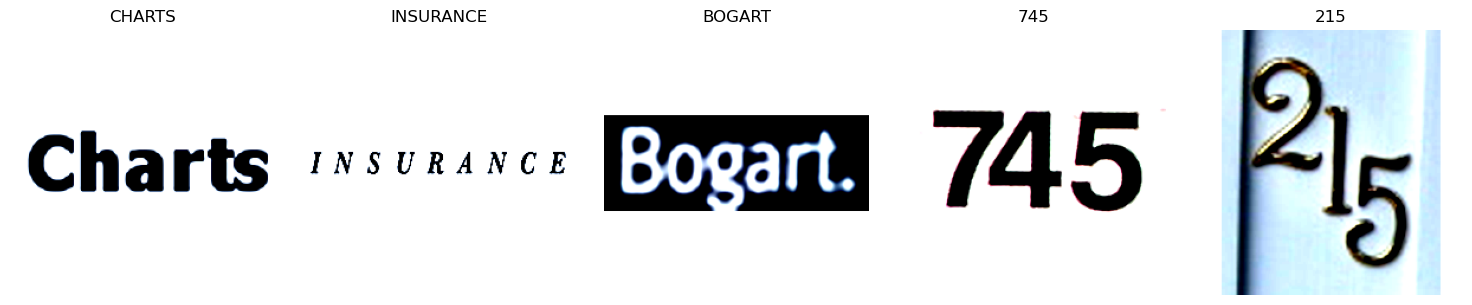

In [96]:
batch = next(iter(train_loader))

images = batch["images"]
texts = batch["raw_texts"]
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img = images[i]
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        
    axs[i].imshow(img)
    axs[i].set_title(texts[i])
    axs[i].axis("off")

plt.tight_layout()
plt.show()


In [97]:
class OCRDecoder(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=512, num_classes=len(vocab)):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True, dropout=0.3)
        self.classifier = nn.Sequential(nn.Dropout(0.3), nn.Linear(hidden_dim * 2, num_classes))

    def forward(self, x):
        x, _ = self.lstm(x)              # (B, T, 2H)
        x = self.classifier(x)           # (B, T, C)
        return x.permute(1, 0, 2)        # For CTC: (T, B, C)

In [98]:
model = OCRDecoder().to(device)
model.load_state_dict(torch.load('best_model_synthetic.pth'))
criterion = nn.CTCLoss(blank=0, zero_infinity=True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

C:\Users\afzal\AppData\Local\Temp\ipykernel_32600\3416877833.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_synthetic.pth')

In [99]:
def greedy_decode(logits, vocab):
    pred = logits.argmax(dim=-1).cpu().numpy()  # shape: (T,)

    prev = -1
    output = []
    for p in pred:
        if p != prev and p != 0:  # Skip repeated & blank tokens
            output.append(vocab[p])
        prev = p
    return ''.join(output)

In [100]:
best_val_cer = float('inf')
patience = 5
patience_counter = 0

train_losses = []
val_losses = []

for epoch in range(100):
    model.train()
    total_loss = 0.0

    for batch in train_loader:
        images = batch["images"].to(device)
        labels_concat = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)

        optimizer.zero_grad()

        inputs = {"pixel_values": images}
        with torch.no_grad():
            vision_output = clip_model(**inputs)
            features = vision_output.last_hidden_state

        outputs = model(features)  # (T, B, C)

        batch_size = outputs.size(1)
        input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)

        loss = criterion(outputs, labels_concat, input_lengths, label_lengths)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    #eval
    
    model.eval()
    val_loss = 0.0
    total_cer = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            images = batch["images"].to(device)
            labels_concat = batch["labels"].to(device)
            label_lengths = batch["label_lengths"].to(device)
            raw_texts = batch["raw_texts"]

            inputs = {"pixel_values": images}
            vision_output = clip_model(**inputs)
            features = vision_output.last_hidden_state

            outputs = model(features)  # (T, B, C)

            batch_size = outputs.size(1)
            input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)

            loss = criterion(outputs, labels_concat, input_lengths, label_lengths)
            val_loss += loss.item()
            T, B, C = outputs.shape
            for b in range(B):
                pred_seq = outputs[:, b, :]  # (T, C)
                pred_text = greedy_decode(pred_seq, vocab)
                total_cer += cer(raw_texts[b].lower(), pred_text.lower())
                num_samples += 1

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    avg_cer = total_cer / num_samples if num_samples > 0 else 0
    print(f"Epoch {epoch} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} Average Val CER: {avg_cer:.4f}")    
        
    # Early stopping check
    if avg_cer < best_val_cer:
        best_val_cer = avg_cer
        patience_counter = 0
        torch.save(model.state_dict(), "best_model_real.pth")
        print(f"Validation CER improved, saving model.")
    else:
        patience_counter += 1
        print(f"No improvement in validation CER for {patience_counter} validation steps.")

    if patience_counter >= patience:
        print(f"Early stopping triggered after {epoch} epochs.")
        break    

Epoch 0 - Train Loss: 0.8504 - Val Loss: 0.5635 Average Val CER: 0.1568
Validation CER improved, saving model.
Epoch 1 - Train Loss: 0.4491 - Val Loss: 0.5435 Average Val CER: 0.1375
Validation CER improved, saving model.
Epoch 2 - Train Loss: 0.2933 - Val Loss: 0.5543 Average Val CER: 0.1370
Validation CER improved, saving model.
Epoch 3 - Train Loss: 0.2225 - Val Loss: 0.6061 Average Val CER: 0.1225
Validation CER improved, saving model.
Epoch 4 - Train Loss: 0.1729 - Val Loss: 0.6589 Average Val CER: 0.1340
No improvement in validation CER for 1 validation steps.
Epoch 5 - Train Loss: 0.1618 - Val Loss: 0.6577 Average Val CER: 0.1355
No improvement in validation CER for 2 validation steps.
Epoch 6 - Train Loss: 0.1351 - Val Loss: 0.7094 Average Val CER: 0.1317
No improvement in validation CER for 3 validation steps.
Epoch 7 - Train Loss: 0.1173 - Val Loss: 0.6729 Average Val CER: 0.1191
Validation CER improved, saving model.
Epoch 8 - Train Loss: 0.1016 - Val Loss: 0.8143 Average Va

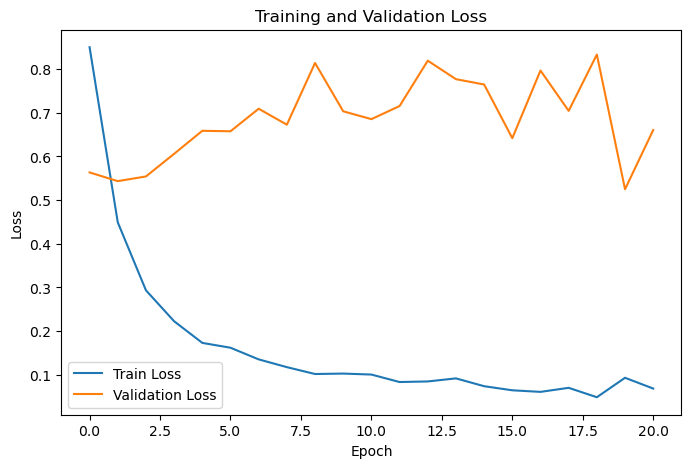

In [106]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [107]:
test_set = IIIT5k(root="IIIT5K", training=True ,transform=clip_transform)
print(len(test_set))

2000


In [111]:
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, collate_fn=collate_fn)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6320349..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.752097..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.1458972].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.1247182..2.1458972].


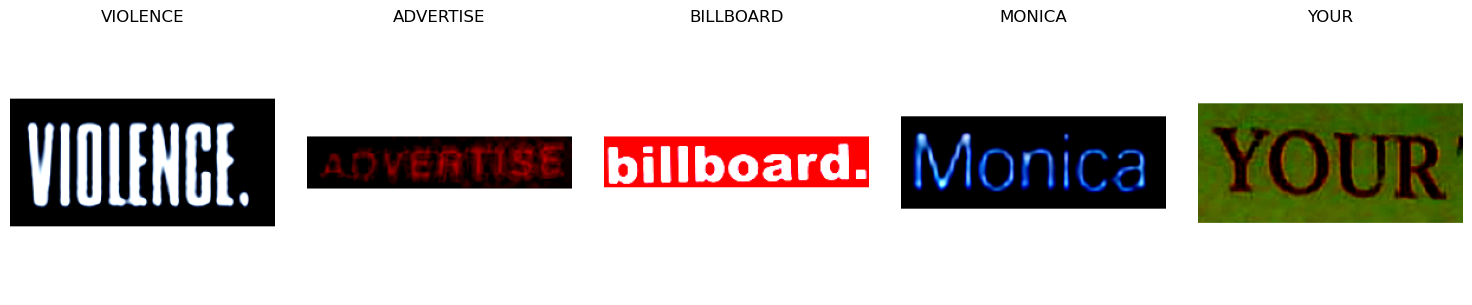

In [112]:
batch = next(iter(test_loader))

images = batch["images"]
texts = batch["raw_texts"]
fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    img = images[i]
    if isinstance(img, torch.Tensor):
        img = img.detach().cpu().permute(1, 2, 0).numpy()
        
    axs[i].imshow(img)
    axs[i].set_title(texts[i])
    axs[i].axis("off")

plt.tight_layout()
plt.show()


In [113]:
model.eval()

with torch.no_grad():
    total_cer = 0.0
    num_samples = 0
    for batch in test_loader:
        images = batch["images"].to(device)
        labels_concat = batch["labels"].to(device)
        label_lengths = batch["label_lengths"].to(device)
        raw_texts = batch["raw_texts"]

        inputs = {"pixel_values": images}
        vision_output = clip_model(**inputs)
        features = vision_output.last_hidden_state

        outputs = model(features)  # (T, B, C)

        batch_size = outputs.size(1)
        input_lengths = torch.full(size=(batch_size,), fill_value=outputs.size(0), dtype=torch.long).to(device)

        loss = criterion(outputs, labels_concat, input_lengths, label_lengths)
        val_loss += loss.item()
        T, B, C = outputs.shape
        for b in range(B):
            pred_seq = outputs[:, b, :]  # (T, C)
            pred_text = greedy_decode(pred_seq, vocab)
            total_cer += cer(raw_texts[b].lower(), pred_text.lower())
            num_samples += 1
            print(f"PREDICTED: {pred_text}   —   GROUND TRUTH: {raw_texts[b].lower()}")

    avg_cer = total_cer / num_samples if num_samples > 0 else 0
    print(f"Average CER: {avg_cer:.4f}")

PREDICTED: on   —   GROUND TRUTH: on
PREDICTED: roman   —   GROUND TRUTH: roman
PREDICTED: fox   —   GROUND TRUTH: fox
PREDICTED: the   —   GROUND TRUTH: the
PREDICTED: sign   —   GROUND TRUTH: sign
PREDICTED: target   —   GROUND TRUTH: target
PREDICTED: your   —   GROUND TRUTH: your
PREDICTED: whoss   —   GROUND TRUTH: whos
PREDICTED: 660   —   GROUND TRUTH: 6470
PREDICTED: werpepei   —   GROUND TRUTH: worldpeipei
PREDICTED: cooper   —   GROUND TRUTH: cooper
PREDICTED: trnoyleds   —   GROUND TRUTH: trinityleeds
PREDICTED: 3d   —   GROUND TRUTH: 3d
PREDICTED: do   —   GROUND TRUTH: do
PREDICTED: use   —   GROUND TRUTH: use
PREDICTED: hilll   —   GROUND TRUTH: hill
PREDICTED: koyah   —   GROUND TRUTH: koyah
PREDICTED: 32   —   GROUND TRUTH: 52
PREDICTED: bank   —   GROUND TRUTH: bank
PREDICTED: wilt   —   GROUND TRUTH: wilt
PREDICTED: smart   —   GROUND TRUTH: smart
PREDICTED: of   —   GROUND TRUTH: of
PREDICTED: 4t7   —   GROUND TRUTH: 4377
PREDICTED: one   —   GROUND TRUTH: one
PREDIC